<a href="https://colab.research.google.com/github/igornunespatricio/BairesDev-Machine-Learning-Practitioner/blob/main/recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Product Recommendation


Building a product recommendation model based on image similarity.

In [1]:
import os

# Upload your kaggle.json file
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!pip install -q -U kaggle > /dev/null 2>&1
!pip install --upgrade --force-reinstall --no-deps kaggle > /dev/null 2>&1
!mkdir ~/.kaggle > /dev/null 2>&1
!cp kaggle.json ~/.kaggle/ > /dev/null 2>&1
!chmod 600 ~/.kaggle/kaggle.json > /dev/null 2>&1

In [3]:
!pip install tensorflow==2.17.1 tensorflow-hub==0.16.1 tensorflow-keras==3.5.0 > /dev/null 2>&1

In [4]:
# necessary when using tensorflow hub model inside sequential, otherwise valueerror is raised.
# link to github issue: https://github.com/tensorflow/tensorflow/issues/63085#issuecomment-2303851416
!pip install tf_keras > /dev/null 2>&1
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [5]:
!kaggle datasets download jessicali9530/caltech256 > /dev/null 2>&1

In [6]:
!unzip caltech256.zip > /dev/null 2>&1

!rm -rf /content/256_ObjectCategories/257.clutter /dev/null 2>&1

In [7]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# version_fn = getattr(tf.keras, "version", None)
# print("TF Keras Version: " + version_fn())

TF version: 2.17.1
Hub version: 0.16.1
GPU is NOT AVAILABLE


In [8]:
import os
import shutil

number_classes = 6

# Define the source and destination directories
source_dir = "/content/256_ObjectCategories"
destination_dir = "/content/data"

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Retrieve and count images in subfolders
subfolder_counts = {
    subfolder: len([
        file for file in os.listdir(os.path.join(source_dir, subfolder))
        if file.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])
    for subfolder in os.listdir(source_dir)
    if os.path.isdir(os.path.join(source_dir, subfolder))
}

# Get the top number_classes categories subfolders with the most images
top_subfolders = sorted(subfolder_counts.items(), key=lambda x: x[1], reverse=True)[:number_classes]

# Copy the top number_classes subfolders and their images to the destination
for subfolder, _ in top_subfolders:
    src_path = os.path.join(source_dir, subfolder)
    dest_path = os.path.join(destination_dir, subfolder)
    shutil.copytree(src_path, dest_path, dirs_exist_ok=True)  # Copies the entire folder structure

print(f"The {number_classes} classes with the most images have been copied to: {destination_dir}")
for subfolder, count in top_subfolders:
    print(f"{subfolder}: {count} images")

The 6 classes with the most images have been copied to: /content/data
251.airplanes-101: 800 images
145.motorbikes-101: 798 images
253.faces-easy-101: 435 images
232.t-shirt: 358 images
096.hammock: 285 images
011.billiards: 278 images


In [9]:
data_dir = '/content/data'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
N_FEATURES = 128

In [10]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,interpolation="bilinear")

train_datagen_kwargs = dict(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    **datagen_kwargs
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**train_datagen_kwargs)
train_generator = train_datagen.flow_from_directory(data_dir, subset="training", shuffle=True, **dataflow_kwargs)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

Found 2365 images belonging to 6 classes.
Found 589 images belonging to 6 classes.


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

module_url = 'https://www.kaggle.com/models/google/bit/TensorFlow2/m-r50x1/1'
module = hub.KerasLayer(module_url, trainable=False)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    module,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(N_FEATURES, name="layer_extractor", activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes)
])

model.build((None,) + IMAGE_SIZE + (3,))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 layer_extractor (Dense)     (None, 128)               262272    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Get class labels and counts from the training generator
class_labels = list(train_generator.class_indices.keys())
class_counts = [np.sum(train_generator.classes == i) for i in range(train_generator.num_classes)]

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)

# Create a dictionary mapping class indices to weights
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.7675635276532138, 1: 1.7288011695906433, 2: 0.616849243609807, 3: 1.373403019744483, 4: 0.6158854166666666, 5: 1.1326628352490422}


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

total_steps = train_generator.samples // train_generator.batch_size

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=total_steps,
    decay_rate=0.9
)

metrics = [
    tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=metrics)

callback_list = [
    ModelCheckpoint(
        filepath='best_model',
        save_best_only=True,
        monitor='val_categorical_accuracy',
        mode='max'
    ),
    EarlyStopping(
        monitor='val_categorical_accuracy',
        patience=3,
        mode='max',
        restore_best_weights=True
    )
]

In [ ]:
hist = model.fit(
    train_generator,
    epochs=5,
    validation_data=valid_generator,
    callbacks=callback_list,
    class_weight=class_weight_dict
)

Epoch 1/5
74/74 [==============================] - 947s 13s/step - loss: 0.1131 - categorical_accuracy: 0.9700 - precision: 0.9212 - recall: 0.9784 - val_loss: 0.0118 - val_categorical_accuracy: 0.9966 - val_precision: 0.9484 - val_recall: 0.9983
Epoch 2/5
74/74 [==============================] - 943s 13s/step - loss: 0.0368 - categorical_accuracy: 0.9915 - precision: 0.9584 - recall: 0.9945 - val_loss: 0.0177 - val_categorical_accuracy: 0.9966 - val_precision: 0.9899 - val_recall: 0.9983
Epoch 3/5
74/74 [==============================] - 903s 12s/step - loss: 0.0285 - categorical_accuracy: 0.9911 - precision: 0.9523 - recall: 0.9970 - val_loss: 0.0118 - val_categorical_accuracy: 0.9983 - val_precision: 0.9916 - val_recall: 0.9983
Epoch 4/5
74/74 [==============================] - 865s 12s/step - loss: 0.0242 - categorical_accuracy: 0.9937 - precision: 0.9562 - recall: 0.9979 - val_loss: 0.0136 - val_categorical_accuracy: 0.9966 - val_precision: 0.9866 - val_recall: 0.9966
Epoch 5/5
74

TypeError: 'History' object is not subscriptable

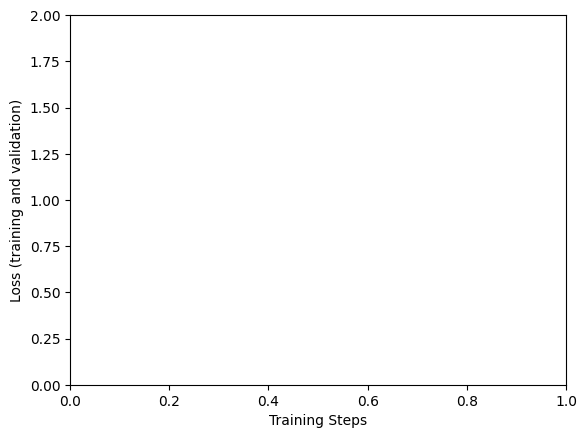

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["categorical_accuracy"])
plt.plot(hist["val_categorical_accuracy"])

In [ ]:
# Load the best model according to validation categorical accuracy
# best_model = tf.keras.models.load_model('/content/best_model')

import tensorflow as tf

# Assuming your original model is called 'model'
# Get the input and output layers
input_layer = model.input
output_layer = model.get_layer('layer_extractor').output

# Create a new model with the input of the original model and output of the 'layer_extractor' layer
feature_extractor = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Save the submodel (this will save the model until 'layer_extractor' layer)
feature_extractor.save('/content/feature_extractor', save_format='tf')

In [ ]:
!zip -r /content/models.zip /content/best_model /content/feature_extractor > /dev/null 2>&1
from google.colab import files
files.download('/content/models.zip')

  adding: content/best_model/ (stored 0%)
  adding: content/best_model/assets/ (stored 0%)
  adding: content/best_model/fingerprint.pb (stored 0%)
  adding: content/best_model/variables/ (stored 0%)
  adding: content/best_model/variables/variables.index (deflated 80%)
  adding: content/best_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/best_model/saved_model.pb (deflated 92%)
  adding: content/best_model/keras_metadata.pb (deflated 87%)
  adding: content/feature_extractor/ (stored 0%)
  adding: content/feature_extractor/assets/ (stored 0%)
  adding: content/feature_extractor/fingerprint.pb (stored 0%)
  adding: content/feature_extractor/variables/ (stored 0%)
  adding: content/feature_extractor/variables/variables.index (deflated 81%)
  adding: content/feature_extractor/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/feature_extractor/saved_model.pb (deflated 92%)
  adding: content/feature_extractor/keras_metadata.pb (deflated 85%

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
!unzip /content/models.zip > /dev/null 2>&1

Archive:  /content/models.zip
   creating: content/best_model/
   creating: content/best_model/assets/
 extracting: content/best_model/fingerprint.pb  
   creating: content/best_model/variables/
  inflating: content/best_model/variables/variables.index  
  inflating: content/best_model/variables/variables.data-00000-of-00001  
  inflating: content/best_model/saved_model.pb  
  inflating: content/best_model/keras_metadata.pb  
   creating: content/feature_extractor/
   creating: content/feature_extractor/assets/
 extracting: content/feature_extractor/fingerprint.pb  
   creating: content/feature_extractor/variables/
  inflating: content/feature_extractor/variables/variables.index  
  inflating: content/feature_extractor/variables/variables.data-00000-of-00001  
  inflating: content/feature_extractor/saved_model.pb  
  inflating: content/feature_extractor/keras_metadata.pb  


In [12]:
# Load feature extractor
feature_extractor = tf.keras.models.load_model('/content/content/feature_extractor')

In [13]:
from pathlib import Path
from tqdm import tqdm

image_dir = '/content/data'
output_dir = '/content/features'

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to load and preprocess images
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)  # Decode as RGB
    img = tf.image.resize_with_pad(img, 224, 224)  # Resize image to 224x224
    img = tf.image.convert_image_dtype(img, tf.float32)  # Convert image to float32
    img = img[tf.newaxis, ...]  # Add batch dimension
    return img

# Loop over all jpg images in the directory
for img_path in tqdm(Path(image_dir).rglob('*.jpg')):
    # Load and preprocess image
    img = load_img(str(img_path))

    # Extract features using the submodel
    features = feature_extractor(img)

    # Squeeze the output to remove the batch dimension
    feature_vector = np.squeeze(features)

    # Generate file name for feature vector (same as image name)
    filename = os.path.basename(img_path).split('.')[0] + '.npz'
    feature_path = os.path.join(output_dir, filename)

    # Save the feature vector to a .npz file
    np.savez(feature_path, feature_vector)

2954it [19:57,  2.47it/s]


In [14]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552448 sha256=6c93d0fce9a1403df1d327740ea366fb4a5214ce52cd39949a9b98a985877e1b
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [15]:
from annoy import AnnoyIndex
import pickle

# Initialize AnnoyIndex
dims = 128  # Dimension of the feature vectors (ensure this matches your model's output dimension)
n_trees = 50  # Number of trees for Annoy (higher values give better accuracy but slower performance)
annoy_index = AnnoyIndex(dims, metric='angular')

# Load all feature vectors into the AnnoyIndex

idx2filename = {}  # Map index to file names
idx2vector = {}  # Map index to feature vectors

# Loop through all saved feature vectors
for idx, feature_file in enumerate(tqdm(os.listdir(output_dir))):
    # Load the feature vector from the file
    feature_path = os.path.join(output_dir, feature_file)
    feature_data = np.load(feature_path)['arr_0']  # .npz file has the array under the key 'arr_0'

    # Add the feature vector to AnnoyIndex
    annoy_index.add_item(idx, feature_data)

    # Save the index to lookup dictionaries
    idx2filename[idx] = feature_file.split('.')[0]
    idx2vector[idx] = feature_data

# Build the index with the desired number of trees
annoy_index.build(n_trees)

# Save the Annoy index (optional)
annoy_index.save('/content/annoy_index.ann')
pickle.dump(idx2filename, open("/content/idx2filename.p", "wb"))
pickle.dump(idx2vector, open("/content/idx2vector.p", "wb"))

# Load the Annoy index (if needed later)
# annoy_index.load('/content/annoy_index.ann')

100%|██████████| 2954/2954 [00:01<00:00, 1975.19it/s]


In [22]:
# Loading annoy and mappings
from annoy import AnnoyIndex
import pickle
import numpy as np

# Specify dimensions and metric (must match what was used during saving)
dims = 128
metric = 'angular'

# Initialize AnnoyIndex with the same dimensions and metric
annoy_index = AnnoyIndex(dims, metric=metric)

# Load the Annoy index
annoy_index.load('/content/annoy_index.ann')  # Path to the saved Annoy index file

# Load the index-to-filename dictionary
idx2filename = pickle.load(open("/content/idx2filename.p", "rb"))

# Load the index-to-vector dictionary (optional, use if needed)
idx2vector = pickle.load(open("/content/idx2vector.p", "rb"))

print("Annoy index and mappings successfully loaded!")


Annoy index and mappings successfully loaded!


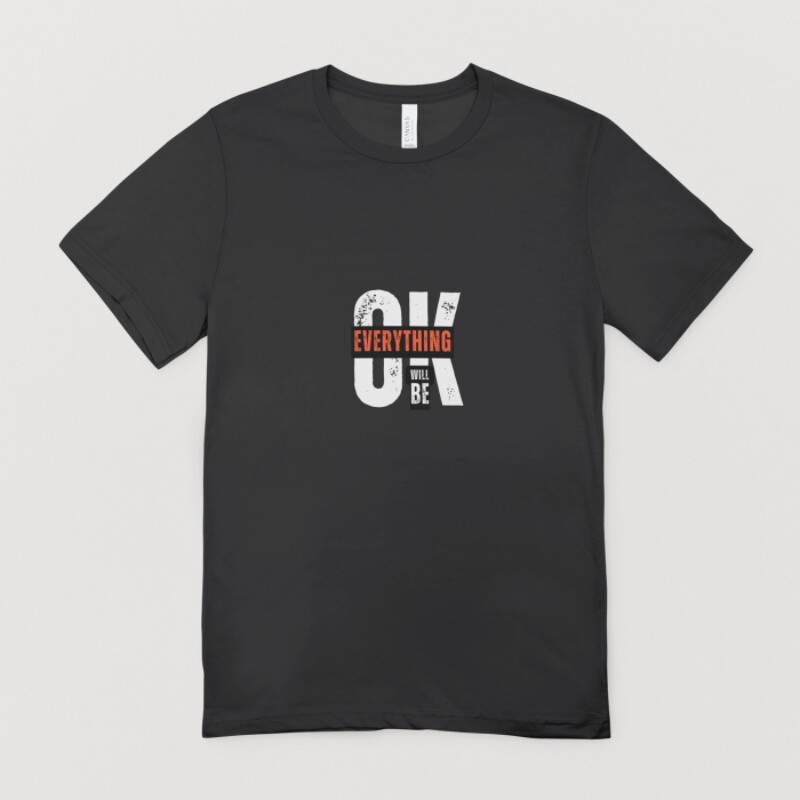

Nearest neighbors are:


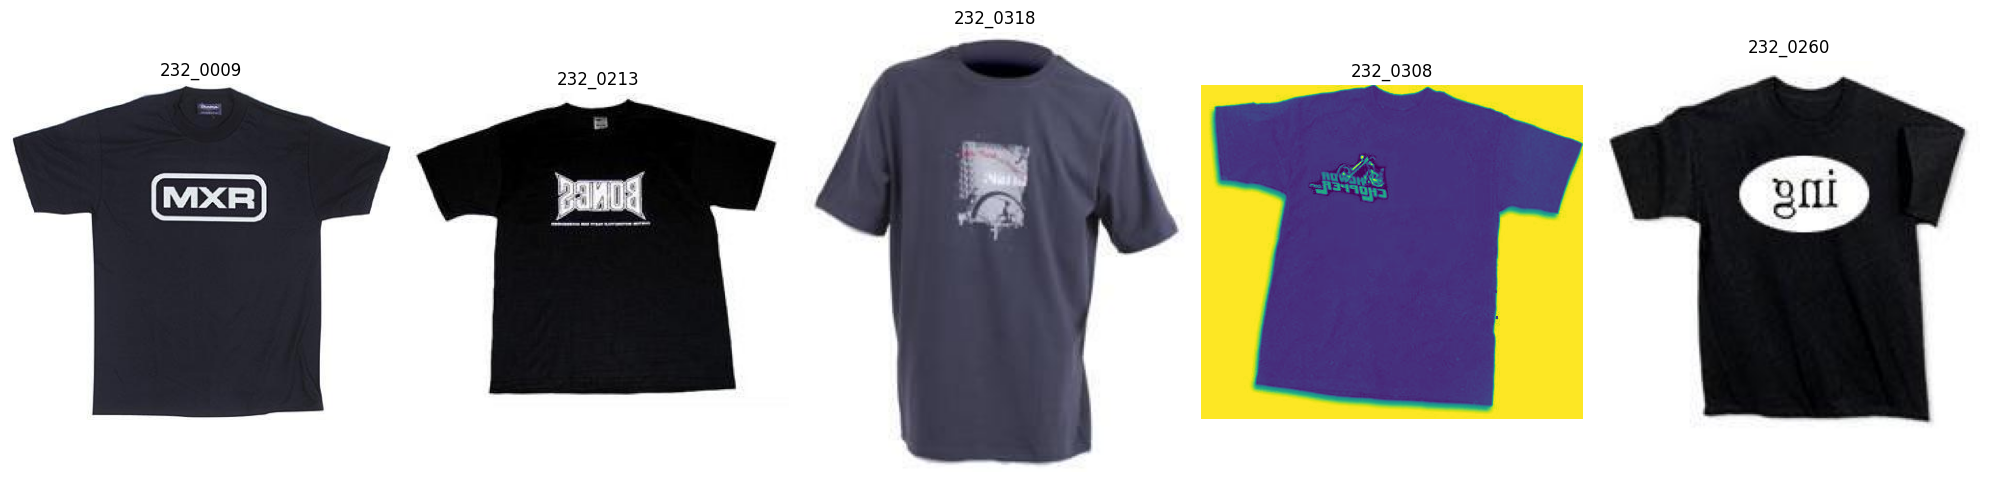

In [23]:
import matplotlib.image as mpimg
from IPython.display import Image, display

# Example: Query the nearest neighbors for a specific image feature vector
test_image_path = '/content/tshirt.jpg'  # Path to the query image feature vector

display(Image(filename=test_image_path))
test_feature_vector = np.squeeze(feature_extractor(load_img(test_image_path)))

# Number of nearest neighbors to retrieve
n_neighbors = 5

# Get the indices of the nearest neighbors
nearest_neighbors = annoy_index.get_nns_by_vector(test_feature_vector, n_neighbors)

# Retrieve and print the corresponding file names for the nearest neighbors
path_dict = {}
for path in Path('/content/data').rglob('*.jpg'):
  path_dict[path.name] = path

plt.figure(figsize=(20, 10))
print(f"Nearest neighbors are:")
for i, neighbor_idx in enumerate(nearest_neighbors):
    filename = idx2filename[neighbor_idx].split('.')[0]
    img_path = f'{path_dict[f"{filename}.jpg"]}'
    plt.subplot(1, n_neighbors, i+1)
    plt.title(filename)
    plt.imshow(mpimg.imread(img_path))
    plt.axis('off')
plt.tight_layout()